# Static potential with fermions: 3x2 lattice m=2 and truncation l=1

In [1]:
%load_ext autoreload
%autoreload 2

## Setup imports and plotting functions

In [1]:
import qiskit

from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../")  # go to parent dir
from itertools import permutations, product
import datetime
import scipy.sparse as sp
from time import perf_counter


from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz
from Observables import *


# Qiskit import
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_distribution
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import re
import matplotlib as mpl

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "14"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"

# Set the font family to a serif font available on your system (e.g., 'Times New Roman')
plt.rcParams["font.serif"] = ["Times New Roman"]

# Disable TeX rendering
plt.rcParams["text.usetex"] = False


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

## Setup Hamiltonian

### Lattice object

In [4]:
# class input parameters:
n_sites = [3, 2]  # how many sites for every dimension
g = 1
fact_e_op = 1
fact_b_op = 1
m = 2
omega = 1
sl = 1
L = 8
rotors = False
lambd = 1000
encoding = "gray"  ##'ed'#
magnetic_basis = False
pbc = False
puregauge = False
static_charges_values = None  # {(0,0):1,(1,0):-1} #TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian = False
e_op_out_plus = False  # if E out of site n has plus sign
sparse_pauli = False  # false for circuit ansatz
# exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 1

# lattice
latt = HCLattice(n_sites, pbc=pbc, puregauge=puregauge)

# static charge
latt.func_qstatic_dist()  # charge=(1,0))
static_charges_values_input = latt.distances_coord
print(static_charges_values_input, set(latt.r_list))
qstat = static_charges_values_input[-1]

# qstat={(0,0):-1,(2,1):1}
# latt.func_qstatic_dist((2,1),ch_val=2)

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (1, 0): 1} {(0, 0): -1, (2, 1): 1}] {1.0, 2.23606797749979}


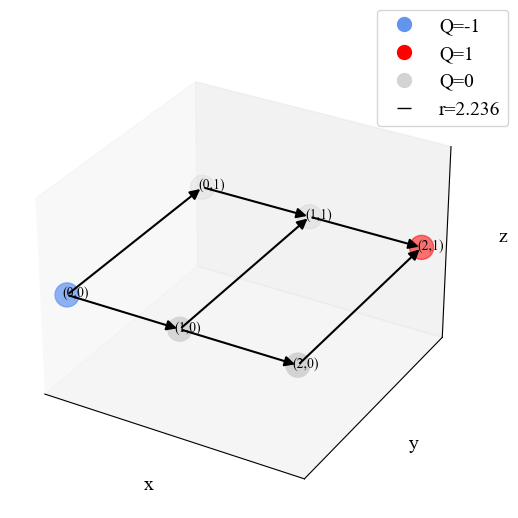

In [5]:
# [latt.draw_graph_func(gauss_law_fig=False,static_charges=st) for st in static_charges_values_input]
latt.draw_graph_func(gauss_law_fig=False, static_charges=qstat)  # ,savefig_dir='.')

## Parametric Hamiltonian

In [6]:
from sympy import Symbol

e_op_free_input = [
    "q_10",
    "q_20",
    "q_21",
    "q_11",
    "q_01",
    "E_10y",
    "E_20y",
]  # if fermions then also put charges!
e_op_free_input = [Symbol(e) for e in e_op_free_input]

# Creating a configuration dictionary with common inputs
config = {
    "latt": latt,
    "n_sites": n_sites,
    "l": sl,
    "L": L,
    "encoding": encoding,
    "magnetic_basis": magnetic_basis,
    "pbc": pbc,
    "puregauge": puregauge,
    "static_charges_values": qstat,
    "e_op_out_plus": e_op_out_plus,
    "e_op_free_input": e_op_free_input,
}
hamilt_sym = HamiltonianQED_sym(config, display_hamiltonian=True)
class_H_oprt = HamiltonianQED_oprt(config, hamilt_sym, sparse_pauli=sparse_pauli)


ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits = int(np.ceil(np.log2(2 * sl + 1)))

Alpha angle α=2 π/2L+1
HamiltonianQED_sym: Initializing...
>> Gauss law system of equations (symbolic + latex):
static charges: ['Q_00=-1', 'Q_21=1']


Eq(-E_00x - E_00y - q_00 + 1, 0)

Eq(E_00y - E_01x - q_01, 0)

Eq(E_00x - E_10x - E_10y - q_10, 0)

Eq(E_01x + E_10y - E_11x - q_11, 0)

Eq(E_10x - E_20y - q_20, 0)

Eq(E_11x + E_20y - q_21 - 1, 0)

Eq(q_00 + q_01 + q_10 + q_11 + q_20 + q_21, 0)

- E_{00x} - E_{00y} - q_{00} + 1 &= 0 \\ \nonumber
E_{00y} - E_{01x} - q_{01} &= 0 \\ \nonumber
E_{00x} - E_{10x} - E_{10y} - q_{10} &= 0 \\ \nonumber
E_{01x} + E_{10y} - E_{11x} - q_{11} &= 0 \\ \nonumber
E_{10x} - E_{20y} - q_{20} &= 0 \\ \nonumber
E_{11x} + E_{20y} - q_{21} - 1 &= 0 \\ \nonumber
q_{00} + q_{01} + q_{10} + q_{11} + q_{20} + q_{21} &= 0 

> Gauss law equations solved
> e_op_free and u_op_free built
>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + E_20y**2 + (E_20y + q_20)**2 + (-E_20y + q_21 + 1)**2 + (E_10y + E_20y + q_10 + q_20)**2 + (-E_10y - E_20y + q_11 + q_21 + 1)**2 + (-E_10y - E_20y + q_01 + q_11 + q_21 + 1)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + E_{20y}^{2} + \left(E_{20y} + q_{20}\right)^{2} + \left(- E_{20y} + q_{21} + 1\right)^{2} + \left(E_{10y} + E_{20y} + q_{10} + q_{20}\right)^{2} + \left(- E_{10y} - E_{20y} + q_{11} + q_{21} + 1\right)^{2} + \left(- E_{10y} - E_{20y} + q_{01} + q_{11} + q_{21} + 1\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + U_20y*Dagger(U_10y) + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + U_{20y} U_{10y}^{\dagger} + h.c.}{2 g^{2}}


Eq(H_K, Omega*(-0.5*(h.c.(y) + Dagger(Phi_1)*Phi_6 - Dagger(Phi_2)*Dagger(U_10y)*Phi_5 + Dagger(Phi_3)*Dagger(U_20y)*Phi_4) + 0.5*I*(-h.c.(x) + Dagger(Phi_1)*Phi_2 + Dagger(Phi_2)*Phi_3 + Dagger(Phi_5)*Phi_4 + Dagger(Phi_6)*Phi_5)))

H_{K} = \Omega \left(- 0.5 \left(h.c.(y) + \Phi_{1}^{\dagger} \Phi_{6} - \Phi_{2}^{\dagger} U_{10y}^{\dagger} \Phi_{5} + \Phi_{3}^{\dagger} U_{20y}^{\dagger} \Phi_{4}\right) + 0.5 i \left(- h.c.(x) + \Phi_{1}^{\dagger} \Phi_{2} + \Phi_{2}^{\dagger} \Phi_{3} + \Phi_{5}^{\dagger} \Phi_{4} + \Phi_{6}^{\dagger} \Phi_{5}\right)\right)


Eq(H_m, m*(Dagger(Phi_1)*Phi_1 - Dagger(Phi_2)*Phi_2 + Dagger(Phi_3)*Phi_3 - Dagger(Phi_4)*Phi_4 + Dagger(Phi_5)*Phi_5 - Dagger(Phi_6)*Phi_6))

H_{m} = m \left(\Phi_{1}^{\dagger} \Phi_{1} - \Phi_{2}^{\dagger} \Phi_{2} + \Phi_{3}^{\dagger} \Phi_{3} - \Phi_{4}^{\dagger} \Phi_{4} + \Phi_{5}^{\dagger} \Phi_{5} - \Phi_{6}^{\dagger} \Phi_{6}\right)
>> Gauss law applied and Hamiltonian built.  Execution time: 0.10575294494628906 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 3.7114460468292236 seconds
Hamiltonian suppr fermions...
Hamiltonian suppr fermions done
>> Suppression term built.  Execution time: 0.0065920352935791016 seconds


### Check properties of Hamiltonian

In [7]:
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(
    g_var=g, m_var=m, omega=omega, fact_b_op=fact_b_op, fact_e_op=fact_b_op, lambd=0
).simplify()
print(
    "Partition a SparsePauliOp into sets of commuting Pauli strings:",
    len(Hamiltonian_Pauli_tot_vqd.group_commuting()),
)

Partition a SparsePauliOp into sets of commuting Pauli strings: 8


In [8]:
(
    class_H_oprt.qop_list[::-1] + class_H_oprt.uop_list[::-1]
)  # order of operators in tensor product and on circuit little endian ..q2q1q0

[q_01, q_11, q_21, q_20, q_10, q_00, U_20y, U_10y]

In [9]:
# print('or charges')
for i, k in enumerate(class_H_oprt.uop_list + class_H_oprt.qop_list):
    print(f"qubit{i}:{k}")

qubit0:U_10y
qubit1:U_20y
qubit2:q_00
qubit3:q_10
qubit4:q_20
qubit5:q_21
qubit6:q_11
qubit7:q_01


## Quantum circuit: with fermions

### Parametric ansatz circuit in `qiskit`

In [10]:
nlayers = 1
entanglement = "full"  # triangular,linear,full
rzlayer = False
ansatz_class = Ansatz(
    sl,
    ngauge,
    nfermions=n_qubits_f,
    gauge_list=class_H_oprt.uop_list,
    ferm_list=class_H_oprt.qop_list,
)


def params(i):
    return Parameter(f"θ[{i}]")


qc_gauge, first_layer_par, th_gauge = ansatz_class.puregauge_circuit_entang(
    entanglement=entanglement, rzlayer=rzlayer, nlayers=nlayers
)

qreg_g = []
qreg_f = []
if ansatz_class.gauge_list:
    for i in [str(k) for k in ansatz_class.gauge_list]:
        qreg_g.append(QuantumRegister(ansatz_class.n_qubits, name=i))
else:
    for i in range(ansatz_class.ngauge):
        qreg_g.append(QuantumRegister(ansatz_class.n_qubits, name=f"g{i}"))
if ansatz_class.ferm_list:
    for f in [str(i) for i in ansatz_class.ferm_list]:
        qreg_f.append(QuantumRegister(1, name=f))
else:
    for i in range(ansatz_class.nfermions):
        qreg_f.append(QuantumRegister(1, name=f"f{i}"))

qc_tot2 = QuantumCircuit(*qreg_g, *qreg_f)

# gauge part
qc_tot2.compose(
    qc_gauge, range(ansatz_class.ngauge * ansatz_class.n_qubits), inplace=True
)

# fermionic part
qc_ferm, th = ansatz_class.fermionic_circuit(th_ferm=th_gauge, nlayers=2)
qc_tot2.compose(
    qc_ferm,
    range(
        ansatz_class.ngauge * ansatz_class.n_qubits,
        ansatz_class.ngauge * ansatz_class.n_qubits + ansatz_class.nfermions,
    ),
    inplace=True,
)

qc_tot2.barrier()

for pair in [[0, 5, 8], [1, 5, 8], [2, 6, 7], [3, 6, 7]]:
    qc_tot2.append(Ansatz.CiSwap2(params(th)), pair)
    th += 1

# rz layer for fermions
for i in range(
    ansatz_class.ngauge * ansatz_class.n_qubits,
    ansatz_class.ngauge * ansatz_class.n_qubits + ansatz_class.nfermions,
):
    qc_tot2.rz(params(th), i)
    th += 1

In [11]:
print("Total numer of gates", qc_tot2.decompose(reps=6).count_ops())

Total numer of gates OrderedDict([('u', 247), ('cx', 152), ('barrier', 1)])


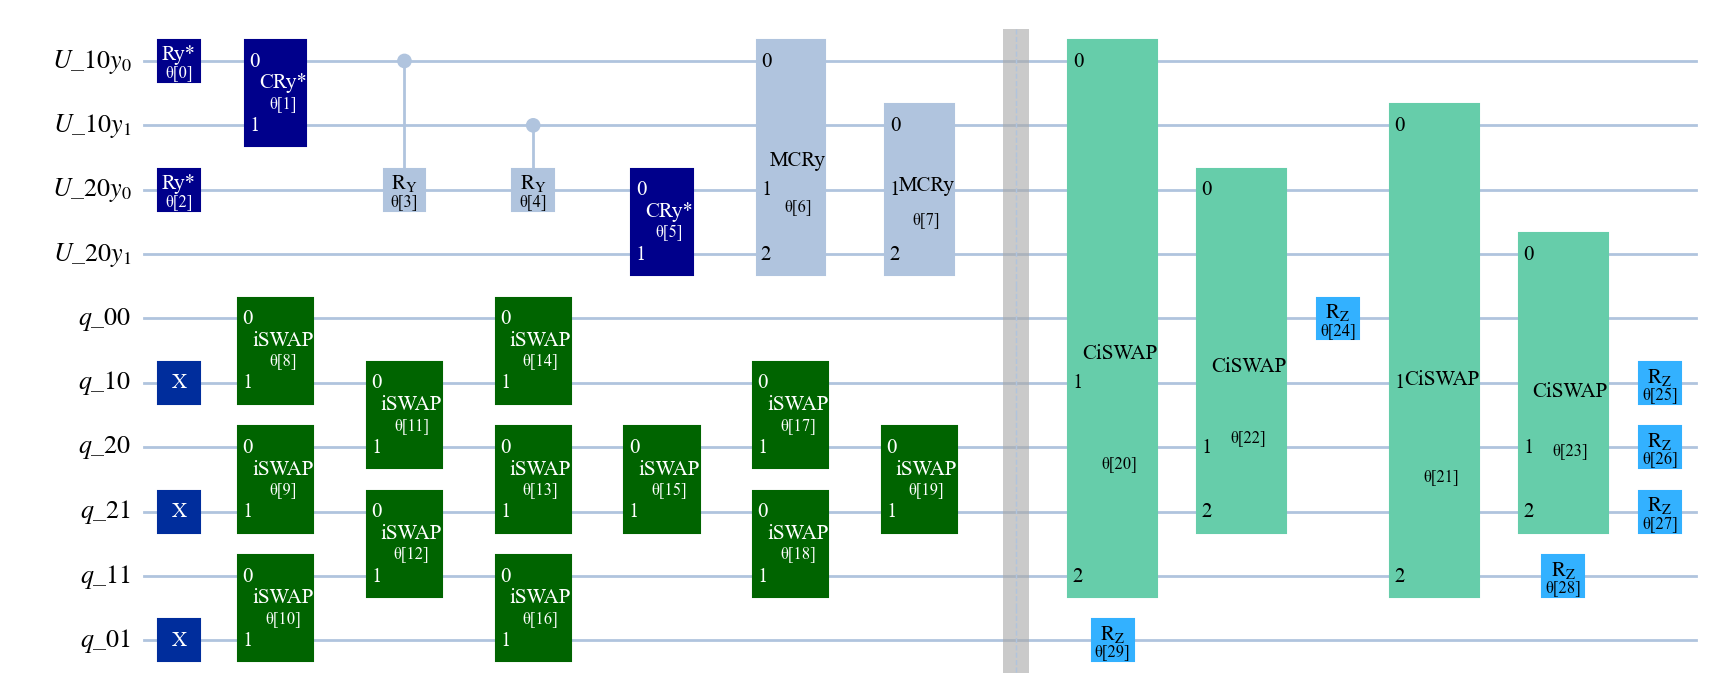

In [12]:
qc_tot2.draw("mpl", fold=50, style=ansatz_class.style)

### Translate to `pytket` using `pytket-qiskit`

In [13]:
from pytket.extensions.qiskit.qiskit_convert import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter
from pytket.circuit import Circuit
from pytket.utils import gate_counts
from pytket.passes import DecomposeBoxes

In [14]:
# From qiskit to pytket
circuit = qiskit_to_tk(qc_tot2)


# map between qubits of the old circuit and the new circuit
new_circuit = Circuit(len(circuit.qubits))
orig = circuit.qubits
new = new_circuit.qubits
map_rename = {
    orig[0]: new[0],
    orig[1]: new[1],
    orig[2]: new[2],
    orig[3]: new[3],
    orig[4]: new[4],
    orig[6]: new[5],
    orig[8]: new[6],
    orig[9]: new[7],
    orig[7]: new[8],
    orig[5]: new[9],
}
circuit.rename_units(map_rename)
print(gate_counts(circuit))

Counter({<OpType.CircBox: 87>: 22, <OpType.Rz: 36>: 6, <OpType.X: 23>: 3, <OpType.CRy: 57>: 2, <OpType.Barrier: 8>: 1})


In [15]:
render_circuit_jupyter(circuit)

#### Decompose the two-qubit gates

In [16]:
DecomposeBoxes().apply(circuit)

True

In [17]:
render_circuit_jupyter(circuit)

print(gate_counts(circuit))

Counter({<OpType.CX: 45>: 96, <OpType.H: 33>: 64, <OpType.Rx: 34>: 64, <OpType.Rz: 36>: 42, <OpType.CRz: 55>: 12, <OpType.Ry: 35>: 6, <OpType.CRy: 57>: 4, <OpType.CCX: 61>: 4, <OpType.X: 23>: 3, <OpType.Barrier: 8>: 1})


In [18]:
# or use a method of the circuit object to count 2qb gates
print(f"Number of 2qb gates in the circuit: {circuit.n_2qb_gates()}")

Number of 2qb gates in the circuit: 112


## Read datafile: VQE results with 10^4 shots and NFT optimizer

Files considered are:
1. run with final string break configuration as initial point,
2. run with 4 configurations vacuum for sites and all cases for gauge fields.

Data saved: coupling "g", exat ground state "ed0", exact ground state eigenstate probabilities (ed_dict={bin str: probability}), 
VQE results, ground state with NFT optimizer and 10^4 shots "vqe0", standard deviation "std_dev", ground state eigenstate probabilities (vqe_dict={bin str: probability}, fidelity, optimal_point to be used with the circuit and Hamiltonian above.

Data computed with electric basis and truncation l=1

In [19]:
nshots = 10_000  # shots used

In [20]:
# read data from file
def read_datafile_glist(filetxt, nshots=None):
    """Read data from files with VQE and exact diagonalisation results.
    Function specific for that type of files."""
    filename = filetxt  # Replace this with the actual path to your file

    # Define regular expressions to extract the required data
    pattern_g = r"g=(-?\d+\.\d+)"
    pattern_ed = r"ed0=(-?\d+\.\d+)"
    pattern_ed_dict = r"ed_dict=\{([\s\S]+?)\}"

    pattern_vqd = r"vqe0=(-?\d+\.\d+)"
    pattern_vqd_dict = r"vqe_dict=\{([\s\S]+?)\}"
    if nshots:
        pattern_std_dev = r"std_dev=(-?\d+\.\d+)"
    pattern_fidelity = r"fidelity=(\d+\.\d+)"
    pattern_parameters = r"optimal_point=\[([\s\d\.\-\+eE]+)\]"

    g_values = []
    ed_values = []
    dict_ed = []
    vqe_values = []
    dict_vqe = []
    std_dev_values = []
    fidelity_values = []
    parameters_values = []

    with open(filename, "r") as file:
        data = file.read()

        g_values = np.array(list(map(float, re.findall(pattern_g, data))))

        # Extract E_0(ED) values
        ed_values = np.array(list(map(float, re.findall(pattern_ed, data))))

        # Extract E_0(VQD) values
        vqe_values = np.array(list(map(float, re.findall(pattern_vqd, data))))

        for k, g in enumerate(g_values):
            # Extract dict_ed string
            list_ed_tmp = [el for el in re.findall(pattern_ed_dict, data)[k].split()]
            # dict index even keys , index odd values
            dict_ed_tmp = {
                eval(list_ed_tmp[i][:-1]): eval(list_ed_tmp[i + 1])
                for i in range(0, len(list_ed_tmp), 2)
            }
            dict_ed_tmp = {
                key: float(v[0]) if isinstance(v, tuple) else float(v)
                for key, v in dict_ed_tmp.items()
            }

            dict_ed.append(dict_ed_tmp)

            # Extract dict_vqe string
            list_vqd_tmp = [el for el in re.findall(pattern_vqd_dict, data)[k].split()]
            # dict index even keys , index odd values
            dict_vqe_tmp = {
                eval(list_vqd_tmp[i][:-1]): eval(list_vqd_tmp[i + 1])
                for i in range(0, len(list_vqd_tmp), 2)
            }
            dict_vqe_tmp = {
                key: float(v[0]) if isinstance(v, tuple) else float(v)
                for key, v in dict_vqe_tmp.items()
            }

            dict_vqe.append(dict_vqe_tmp)

        # Extract std. dev. values
        std_dev_values = np.array(list(map(float, re.findall(pattern_std_dev, data))))

        # Extract Fidelity (|psi_VQDXpsi_ED|^2) values
        fidelity_values = np.array(list(map(float, re.findall(pattern_fidelity, data))))

        # Extract Parameters values
        parameters_matches = re.finditer(pattern_parameters, data)
        # print(parameters_matches)

        parameters_list = [
            np.array(list(map(float, match.group(1).split())))
            for match in parameters_matches
        ]

    return (
        g_values,
        ed_values,
        dict_ed,
        vqe_values,
        std_dev_values,
        dict_vqe,
        fidelity_values,
        parameters_list,
    )

Data plotted in the following are from g=0.3 (better visualisation of the string breaking)

Higher fidelity 1st case: 0.9627 0.954
Higher fidelity 2nd case: 0.9703 0.9706
Higher fidelity 2nd case: 0.9717 0.9733
Higher fidelity 1st case: 0.973 0.9728
Higher fidelity 2nd case: 0.9688 0.969
Higher fidelity 1st case: 0.9646 0.9635
Higher fidelity 2nd case: 0.9512 0.9554
Higher fidelity 2nd case: 0.9246 0.9477
Higher fidelity 2nd case: 0.9008 0.9482
Higher fidelity 1st case: 0.9983 0.0002
Higher fidelity 1st case: 0.9989 0.0001
Higher fidelity 1st case: 0.9993 0.0001
Higher fidelity 1st case: 0.9996 0.0002
Higher fidelity 1st case: 0.9996 0.0006
Higher fidelity 1st case: 0.9997 0.0015
Higher fidelity 1st case: 0.9998 0.0023


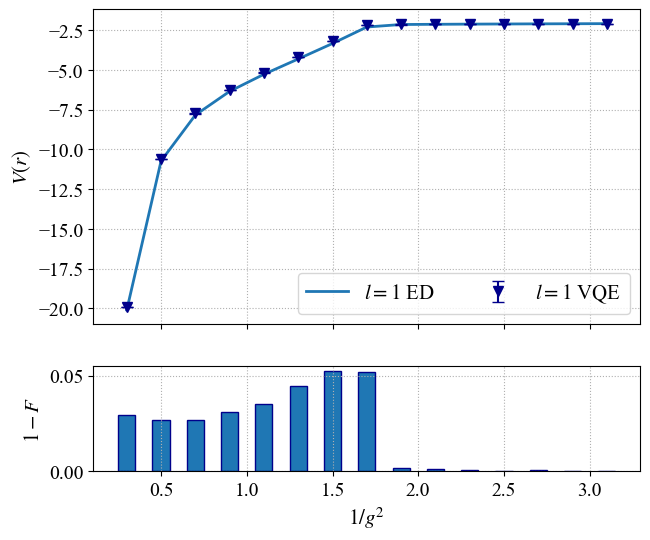

In [21]:
# Read data file
(
    g_values_file,
    ed_values_file,
    dict_ed_file,
    vqe_values_file,
    std_dev_values_file,
    dict_vqe_file,
    fidelity_values_file,
    parameters_list_file,
) = read_datafile_glist(
    "static_potential_3x2_m2_omega1_l1_mutualinfoansatz.txt", nshots=nshots
)
(
    g_values_file_v2,
    ed_values_file_v2,
    dict_ed_file_v2,
    vqe_values_file_v2,
    std_dev_values_file_v2,
    dict_vqe_file_v2,
    fidelity_values_file_v2,
    parameters_list_file_v2,
) = read_datafile_glist(
    "static_potential_3x2_m2_omega1_l1_mutualinfoansatz_v2.txt", nshots=nshots
)

width = 510
# select in the two files which one has hogher fidelity in the results. The difference is related to the choice of the initial point.
for fid, fid_2, i in zip(
    fidelity_values_file, fidelity_values_file_v2, range(len(g_values_file))
):
    if fid >= fid_2:  # first run with final string break configuration as initial point
        print("Higher fidelity 1st case:", np.round(fid, 4), np.round(fid_2, 4))
    else:  # second run with 4 configurations vacuum for sites and all cases for gauge fields
        print("Higher fidelity 2nd case:", np.round(fid, 4), np.round(fid_2, 4))
        g_values_file[i] = g_values_file_v2[i]
        ed_values_file[i] = ed_values_file_v2[i]
        dict_ed_file[i] = dict_ed_file_v2[i]
        vqe_values_file[i] = vqe_values_file_v2[i]
        dict_vqe_file[i] = dict_vqe_file_v2[i]
        std_dev_values_file[i] = std_dev_values_file_v2[i]
        fidelity_values_file[i] = fidelity_values_file_v2[i]
        parameters_list_file[i] = parameters_list_file_v2[i]


fig, ax = plt.subplots(
    2,
    figsize=(set_size(width)[0], 6),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},
)

ax[0].plot(
    g_values_file[1:],
    ed_values_file[1:],
    markersize=6,
    markeredgewidth=2,
    label="$l=1$ ED",
    linewidth=2,
)
ax[0].errorbar(
    g_values_file[1:],
    vqe_values_file[1:],
    yerr=std_dev_values_file[1:],
    marker="v",
    markersize=7,
    color="darkblue",
    label="$l=1$ VQE",
    linestyle="",
    capsize=4,
)
ax[0].set_ylabel(r"$V(r)$", fontsize=15)
ax[0].legend(fontsize=15, ncols=3, loc="lower right")

# ax[1].bar(g_list,np.abs(np.array(vqe_results)-np.array(ed_results)/np.array(ed_results)), edgecolor='black',width=0.1)
ax[1].bar(
    g_values_file[1:], 1 - fidelity_values_file[1:], edgecolor="darkblue", width=0.1
)

ax[1].set_ylabel(r"$1-F$", fontsize=15)
ax[1].set_xlabel(r"$1/g^2$", fontsize=15)


for i in [0, 1]:
    ax[i].grid(True, which="both", linestyle="dotted")

With "parameters_list_file" one can use the final optimal point in a new run of the circuit.
Here an example of computing expectation value of ground state.

In [22]:
index = 1  # first point in plot
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(
    g_var=g_values_file[index],
    m_var=m,
    omega=omega,
    fact_b_op=fact_b_op,
    fact_e_op=fact_b_op,
    lambd=0,
).simplify()

exp_value = (
    Statevector(qc_tot2.assign_parameters(parameters_list_file[index]))
    .expectation_value(Hamiltonian_Pauli_tot_vqd)
    .real
)

print(f"Expectation value at point {index} is {exp_value}")

Expectation value at point 1 is -19.90101599537944


## Pytket simulations of the circuits using Aer

In [26]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket import Qubit
from collections import defaultdict

from pytket.extensions.qiskit import AerBackend, AerStateBackend
from pytket.utils.distribution import EmpiricalDistribution, ProbabilityDistribution

from pytket.utils import probs_from_counts, probs_from_state

In [24]:
# Functions
def plot_data_func(g_values, dict_tot, legend_labels, backend, nshots, thrsld=1e-2):
    """Return a plot of the probabilities of the different states for each g value.
    Input:
    g_values: list of g values
    dict_tot: list of dictionaries with the probabilities for each g value
    legend_labels: list of labels for the legend
    backend: backend used for the simulation
    nshots: number of shots used
    thrsld: threshold for the probabilities to be plotted

    """

    bar_width = 0.3  # adjust as needed
    cmap = plt.get_cmap("Paired")

    def bar_labels(x_labels, bar_width, index):
        """Return the shifted positions for each dataset."""
        x = np.arange(len(x_labels))
        # Shift positions for each dataset
        if index == 1:
            return x - index * bar_width
        elif index == 2:
            return x
        else:
            return x + (index - 2) * bar_width

    # Function to map x-labels to their index
    def map_index(labels):
        """Return the index of each label in the list of all x-labels."""
        return [all_x_labels.index(label) for label in labels]

    fig, ax = plt.subplots(2, 4, figsize=(15, 6), sharey=True)
    for i, g in zip(range(len(g_values)), g_values):
        all_x_labels = []
        for data in dict_tot:
            dicts = {k: v for k, v in data[i].items() if v > thrsld}
            all_x_labels += list(dicts.keys())
        all_x_labels = list(set(all_x_labels))
        # Create a numerical index for all_x_labels
        x = np.arange(len(all_x_labels))

        for n, data in enumerate(dict_tot):
            dicts = {k: v for k, v in data[i].items() if v > thrsld}

            # Map x-labels to their index for each dataset
            dataset_indices = map_index(list(dicts.keys()))

            ax[i // 4, i % 4].bar(
                x[dataset_indices] + (n - 1) * bar_width,
                list(dicts.values()),
                align="center",
                width=bar_width,
                color=cmap(n),
            )
            ax[i // 4, i % 4].set_xticks(x, all_x_labels)
            ax[i // 4, i % 4].set_title(f"g={np.round(g,2)}", fontsize=15)
            ax[i // 4, i % 4].set_ylabel("Probabilities", fontsize=15)
            ax[i // 4, i % 4].tick_params(axis="x", rotation=45)

    fig.legend(
        legend_labels,
        loc="lower center",
        ncol=3,
        fontsize=15,
        bbox_to_anchor=(0.5, -0.1),
    )
    fig.tight_layout()
    fig.suptitle(
        "Probabilities of the different states for each g value:"
        + backend.backend_info.name
        + f" shots={nshots}",
        fontsize=15,
        y=1.05,
    )
    plt.show()

Checks of conversion:
* Compute statevector using pytket
* Compute fidelity with ED using pytket
* Compute expectation value using pytket

Results:
* Compute shots on simulator/emulator/machine for computation basis states
* Implement symmetry-based post selection (error mitigation)
* Compute expectation values of H (...or other observables...) using shots

Goal:
Reproduce figure of quasi-probability of configuration states with the emulator/device for multiple values of g

In [28]:
# Select only subset of g for running
indices = np.where(np.arange(len(g_values_file)) % 2 != 0)[0]
g_values_file[indices]

array([0.3, 0.7, 1.1, 1.5, 1.9, 2.3, 2.7, 3.1])

### AerStateBackend

In [36]:
aer_backend = AerStateBackend()
nshots = None

In [37]:
dict_aer_tot = []
dict_ed_tot = []
dict_vqe_tot = []
for index, g in zip(indices, g_values_file[indices]):
    print(f"g={np.round(g,2)}")
    dict_ed_tot.append(dict_ed_file[index])
    # dict_vqe_tot.append(dict_vqe_file[index])
    # XXX use last point for vqe results
    dict_vqe_tot.append(
        Statevector(
            qc_tot2.assign_parameters(parameters_list_file[index])
        ).probabilities_dict()
    )

    circuit = qiskit_to_tk(qc_tot2.assign_parameters(parameters_list_file[index]))
    # map between qubits of the old circuit and the new circuit
    new_circuit = Circuit(len(circuit.qubits))
    orig = circuit.qubits
    new = new_circuit.qubits
    map_rename = {
        orig[0]: new[0],
        orig[1]: new[1],
        orig[2]: new[2],
        orig[3]: new[3],
        orig[4]: new[4],
        orig[6]: new[5],
        orig[8]: new[6],
        orig[9]: new[7],
        orig[7]: new[8],
        orig[5]: new[9],
    }
    circuit.rename_units(map_rename)
    # render_circuit_jupyter(circuit)
    circ_compiled = aer_backend.get_compiled_circuit(circuit, optimisation_level=2)

    # visualize circuit
    # render_circuit_jupyter(circ_compiled)
    handle = aer_backend.process_circuit(circ_compiled, n_shots=nshots)
    result = aer_backend.get_result(handle)

    probs = probs_from_state(aer_backend.get_result(handle).get_state())
    dict_aer = {"".join(str(bit) for bit in k[::-1]): v for k, v in probs.items()}
    dict_aer_tot.append(dict_aer)

g=0.3
g=0.7
g=1.1
g=1.5
g=1.9
g=2.3
g=2.7
g=3.1


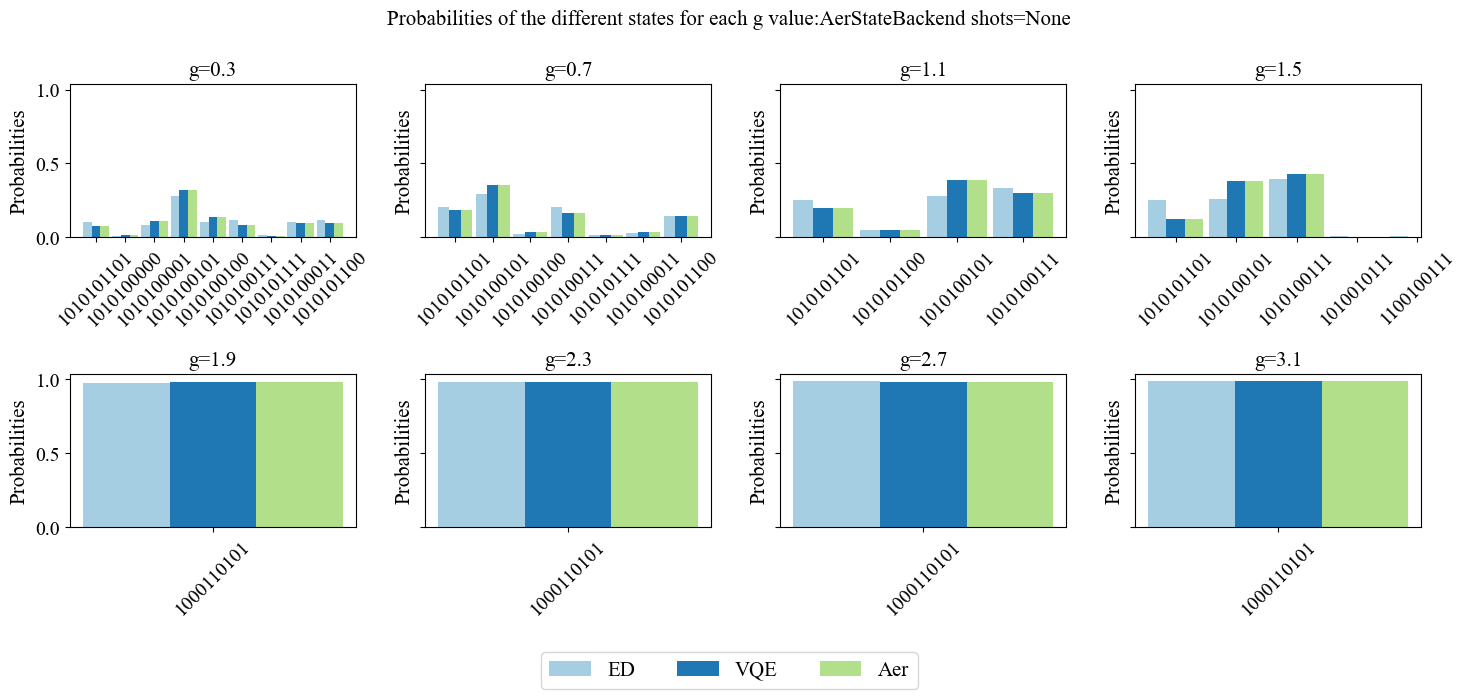

In [38]:
plot_data_func(
    g_values_file[indices],
    [dict_ed_tot, dict_vqe_tot, dict_aer_tot],
    ["ED", "VQE", "Aer"],
    aer_backend,
    nshots,
)

### AerBackend without Noise, with shots

In [31]:
aer_backend = AerBackend()
nshots = 10_000

In [32]:
dict_aer_tot = []
dict_ed_tot = []
dict_vqe_tot = []
for index, g in zip(indices, g_values_file[indices]):
    print(f"g={np.round(g,2)}")
    dict_ed_tot.append(dict_ed_file[index])
    # dict_vqe_tot.append(dict_vqe_file[index])
    # XXX use last point for vqe results
    dict_vqe_tot.append(
        Statevector(
            qc_tot2.assign_parameters(parameters_list_file[index])
        ).probabilities_dict()
    )

    circuit = qiskit_to_tk(qc_tot2.assign_parameters(parameters_list_file[index]))
    # map between qubits of the old circuit and the new circuit
    new_circuit = Circuit(len(circuit.qubits))
    orig = circuit.qubits
    new = new_circuit.qubits
    map_rename = {
        orig[0]: new[0],
        orig[1]: new[1],
        orig[2]: new[2],
        orig[3]: new[3],
        orig[4]: new[4],
        orig[6]: new[5],
        orig[8]: new[6],
        orig[9]: new[7],
        orig[7]: new[8],
        orig[5]: new[9],
    }
    circuit.rename_units(map_rename)
    # render_circuit_jupyter(circuit)
    circ_compiled = aer_backend.get_compiled_circuit(
        circuit.measure_all(), optimisation_level=2
    )

    # visualize circuit
    # render_circuit_jupyter(circ_compiled)
    handle = aer_backend.process_circuit(circ_compiled, n_shots=nshots)
    result = aer_backend.get_result(handle)

    probs = probs_from_counts(aer_backend.get_result(handle).get_counts())
    dict_aer = {"".join(str(bit) for bit in k[::-1]): v for k, v in probs.items()}
    dict_aer_tot.append(dict_aer)

g=0.3
g=0.7
g=1.1
g=1.5
g=1.9
g=2.3
g=2.7
g=3.1


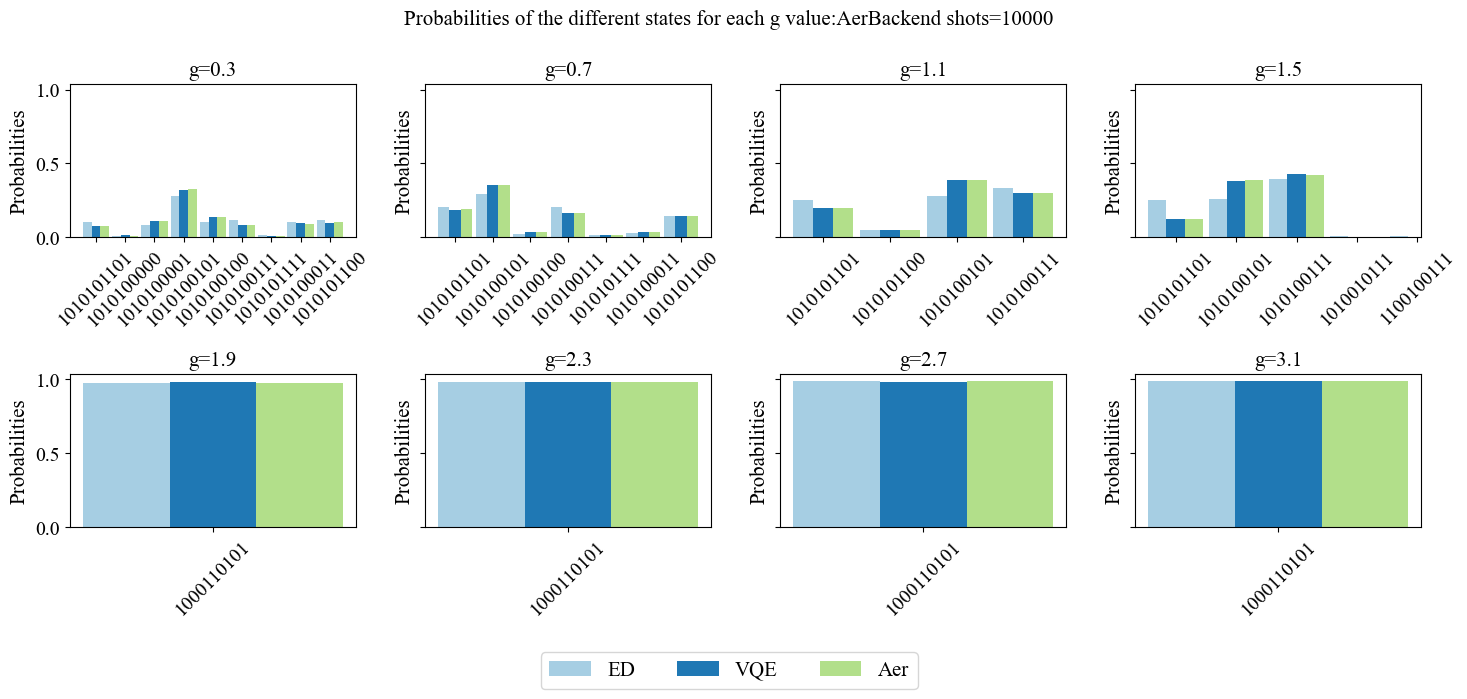

In [33]:
plot_data_func(
    g_values_file[indices],
    [dict_ed_tot, dict_vqe_tot, dict_aer_tot],
    ["ED", "VQE", "Aer"],
    aer_backend,
    nshots,
)

### AerBackend with NoiseModel

In [39]:
from qiskit_ibm_provider import IBMProvider
from qiskit_aer.noise import NoiseModel

# Load a previously saved account.
# provider = IBMProvider(instance="ibm-q-desy/internal/lft")
# backend = provider.get_backend("ibm_cusco")
provider = IBMProvider(instance="ibm-q/open/main")
backend = provider.get_backend("ibm_kyoto")


nshots = 10_000
noisemodel = NoiseModel.from_backend(backend)
aer_backend = AerBackend(noise_model=noisemodel)

In [40]:
dict_aer_tot = []
dict_ed_tot = []
dict_vqe_tot = []
for index, g in zip(indices, g_values_file[indices]):
    print(f"g={np.round(g,2)}")
    dict_ed_tot.append(dict_ed_file[index])
    # dict_vqe_tot.append(dict_vqe_file[index])
    # XXX use last point for vqe results
    dict_vqe_tot.append(
        Statevector(
            qc_tot2.assign_parameters(parameters_list_file[index])
        ).probabilities_dict()
    )

    circuit = qiskit_to_tk(qc_tot2.assign_parameters(parameters_list_file[index]))
    # map between qubits of the old circuit and the new circuit
    new_circuit = Circuit(len(circuit.qubits))
    orig = circuit.qubits
    new = new_circuit.qubits
    map_rename = {
        orig[0]: new[0],
        orig[1]: new[1],
        orig[2]: new[2],
        orig[3]: new[3],
        orig[4]: new[4],
        orig[6]: new[5],
        orig[8]: new[6],
        orig[9]: new[7],
        orig[7]: new[8],
        orig[5]: new[9],
    }
    circuit.rename_units(map_rename)
    # render_circuit_jupyter(circuit)
    circ_compiled = aer_backend.get_compiled_circuit(
        circuit.measure_all(), optimisation_level=2
    )

    # visualize circuit
    # render_circuit_jupyter(circ_compiled)
    handle = aer_backend.process_circuit(circ_compiled, n_shots=nshots)
    result = aer_backend.get_result(handle)

    probs = probs_from_counts(aer_backend.get_result(handle).get_counts())
    dict_aer = {"".join(str(bit) for bit in k[::-1]): v for k, v in probs.items()}
    dict_aer_tot.append(dict_aer)

g=0.3
g=0.7
g=1.1
g=1.5
g=1.9
g=2.3
g=2.7
g=3.1


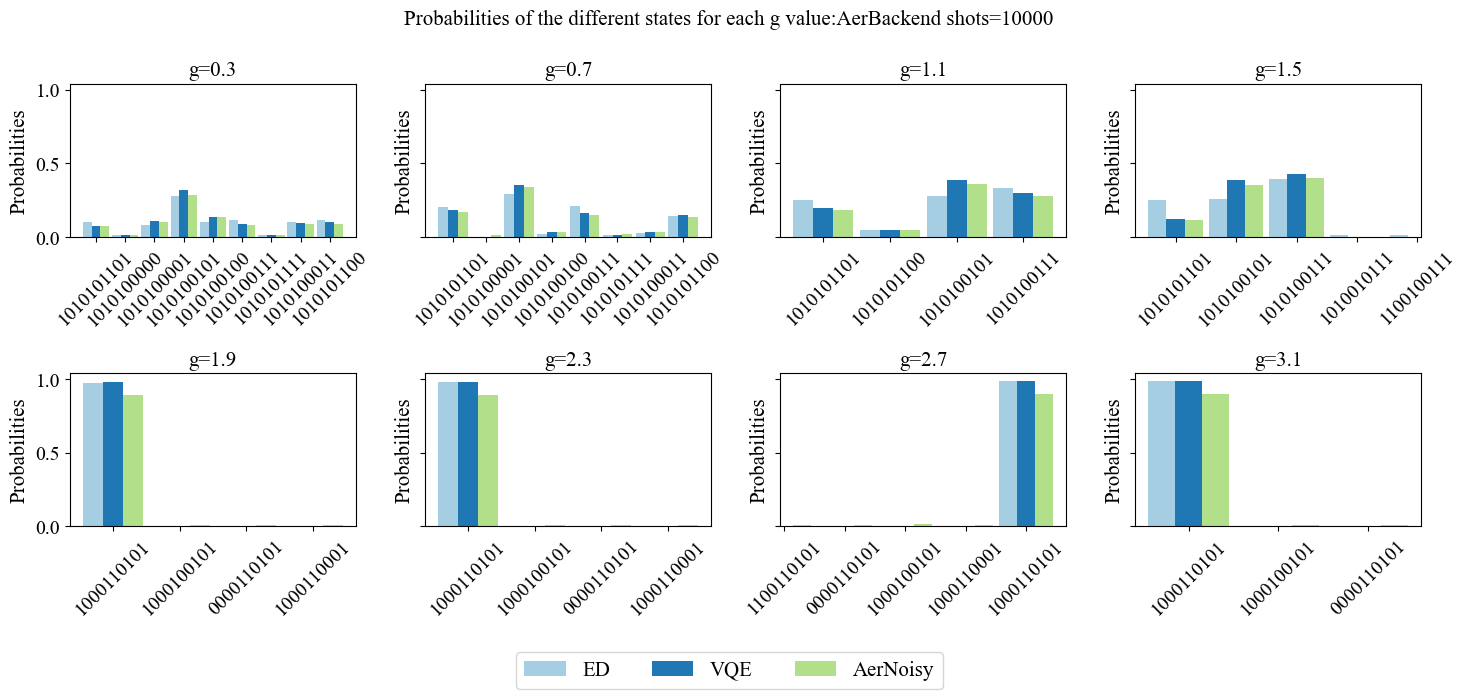

In [42]:
# noise model ibm cusco
plot_data_func(
    g_values_file[indices],
    [dict_ed_tot, dict_vqe_tot, dict_aer_tot],
    ["ED", "VQE", "AerNoisy"],
    aer_backend,
    nshots,
)

In [502]:
for g, dicts in zip(g_values_file[indices], dict_aer_tot):
    print(f"g={np.round(g,2)}")
    # **Check if there are unphysical states
    gray_unph = []
    for i in range(2 * sl + 1, 2 ** int(np.ceil(np.log2(2 * sl + 1)))):
        gray_decimal = i ^ (i >> 1)
        gray_unph.append(
            "{0:0{1}b}".format(gray_decimal, int(np.ceil(np.log2(2 * sl + 1))))
        )

    ferm_q0 = ["".join(i) for i in permutations(["0", "1"] * (n_qubits // 2), n_qubits)]

    print(
        "Check if there are unphysical states: Gauge fields:",
        gray_unph,
        "Fermions: only zero charge are considered physical",
    )
    reduced_dict = {}
    for i in range(num_eigs):
        if ngauge:
            for vqd_res in [
                string[-(ngauge * n_qubits) :][
                    i : i + int(np.ceil(np.log2(2 * sl + 1)))
                ]
                for string in dicts.keys()
                for i in range(
                    0,
                    len(string[-(ngauge * n_qubits) :]),
                    int(np.ceil(np.log2(2 * sl + 1))),
                )
            ]:
                if vqd_res in gray_unph:
                    print("unphysical state reached for gauge fields")
                    break
            else:
                print(f"E_{i} all physical states reached gauge fields: OK!")
        if n_qubits_f:
            for vqd_res in [string[:n_qubits_f] for string in dicts.keys()]:
                if vqd_res in ferm_q0:
                    print("unphysical state reached for fermions")
                    break
            else:
                print(f"E_{i} all physical states reached fermions: OK!")

g=0.3
Check if there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
unphysical state reached for gauge fields
E_0 all physical states reached fermions: OK!
g=0.7
Check if there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
unphysical state reached for gauge fields
E_0 all physical states reached fermions: OK!
g=1.1
Check if there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
unphysical state reached for gauge fields
E_0 all physical states reached fermions: OK!
g=1.5
Check if there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
unphysical state reached for gauge fields
E_0 all physical states reached fermions: OK!
g=1.9
Check if there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
unphysical state reached for gauge fields
E_0 all physical states re

In [ ]:
reduced_dict = {}
unphys_dict = {}
for string, val in dict_aer_tot[0].items():
    count = 0
    # print(string,string[-(ngauge*n_qubits):])
    for i in range(
        0, len(string[-(ngauge * n_qubits) :]), int(np.ceil(np.log2(2 * l + 1)))
    ):
        if (
            string[-(ngauge * n_qubits) :][i : i + int(np.ceil(np.log2(2 * l + 1)))]
            in gray_unph
        ):
            unphys_dict[string] = val
            break
        else:
            reduced_dict[string] = val

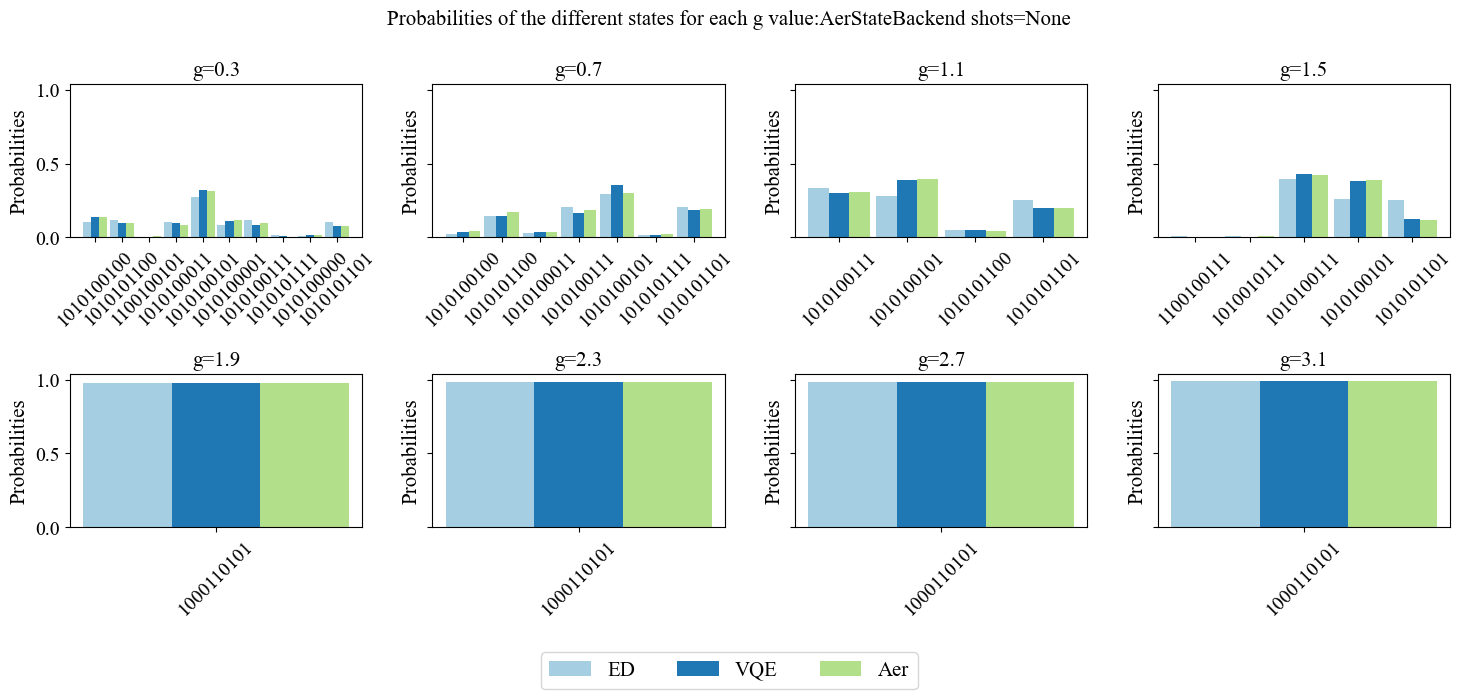

In [466]:
plot_data_func(
    g_values_file[indices],
    [dict_ed_tot, dict_vqe_tot, dict_aer_tot],
    ["ED", "VQE", "Aer"],
    aer_backend,
    nshots,
)

## Expectation value: TODO

In [63]:
index = 1
Hamiltonian_Pauli_tot_ed = class_H_oprt.get_hamiltonian(
    g_var=g_values_file[index],
    m_var=m,
    omega=omega,
    fact_b_op=fact_b_op,
    fact_e_op=fact_b_op,
    lambd=1000,
).simplify()
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(
    g_var=g_values_file[index],
    m_var=m,
    omega=omega,
    fact_b_op=fact_b_op,
    fact_e_op=fact_b_op,
    lambd=0,
).simplify()

In [64]:
from scipy.sparse.linalg import eigsh

vals, vecs = eigsh(Hamiltonian_Pauli_tot_ed.to_matrix(sparse=True), k=1, which="SA")
print(f"Energy of the ground state {vals[0].real}")

Energy of the ground state -20.102521634001985


In [65]:
vals, vecs = eigsh(Hamiltonian_Pauli_tot_vqd.to_matrix(sparse=True), k=1, which="SA")
print(f"Energy of the ground state for VQE {vals[0].real}")

Energy of the ground state for VQE -20.102521634001903


### Transform the Hamiltonian from `qiskit` to `pytket`

In [66]:
pauli_sym = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def qps_from_sparsepauliop(paulis):
    """Convert SparsePauliOp tensor of Paulis to pytket QubitPauliString."""
    qlist = []
    plist = []
    for q, p in enumerate(paulis):
        if p != "I":
            qlist.append(Qubit(q))
            plist.append(pauli_sym[p])
    return QubitPauliString(qlist, plist)


def qpo_from_sparsepauliop(sp_op):
    """Convert SparsePauliOp QubitOperator to pytket QubitPauliOperator."""
    tk_op = defaultdict(complex)
    for term, coeff in sp_op.to_list():
        string = qps_from_sparsepauliop(term)
        tk_op[string] += coeff
    return QubitPauliOperator(tk_op)

In [67]:
hamiltonian_op = qpo_from_sparsepauliop(Hamiltonian_Pauli_tot_vqd)
print(hamiltonian_op)

{(Yq[4], Yq[5]): 0.250000000000000, (Xq[4], Xq[5]): 0.250000000000000, (Xq[0], Xq[1]): -0.250000000000000, (Yq[0], Yq[1]): -0.250000000000000, (Yq[3], Yq[4]): 0.250000000000000, (Xq[3], Xq[4]): 0.250000000000000, (Xq[1], Xq[2]): -0.250000000000000, (Yq[1], Yq[2]): -0.250000000000000, (Xq[0], Zq[1], Zq[2], Zq[3], Zq[4], Yq[5]): 0.250000000000000, (Yq[0], Zq[1], Zq[2], Zq[3], Zq[4], Xq[5]): -0.250000000000000, (Xq[1], Zq[2], Zq[3], Yq[4], Xq[9]): 0.0625000000000000, (Xq[1], Zq[2], Zq[3], Yq[4], Zq[8], Xq[9]): 0.0625000000000000, (Xq[1], Zq[2], Zq[3], Yq[4], Xq[8]): 0.0625000000000000, (Xq[1], Zq[2], Zq[3], Yq[4], Xq[8], Zq[9]): -0.0625000000000000, (Yq[1], Zq[2], Zq[3], Yq[4], Yq[9]): -0.0625000000000000, (Yq[1], Zq[2], Zq[3], Yq[4], Zq[8], Yq[9]): -0.0625000000000000, (Yq[1], Zq[2], Zq[3], Yq[4], Yq[8]): -0.0625000000000000, (Yq[1], Zq[2], Zq[3], Yq[4], Yq[8], Zq[9]): 0.0625000000000000, (Xq[1], Zq[2], Zq[3], Xq[4], Yq[9]): -0.0625000000000000, (Xq[1], Zq[2], Zq[3], Xq[4], Zq[8], Yq[9])

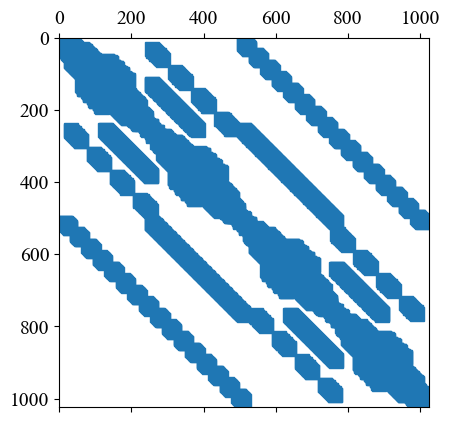

In [74]:
plt.spy(hamiltonian_op.to_sparse_matrix())

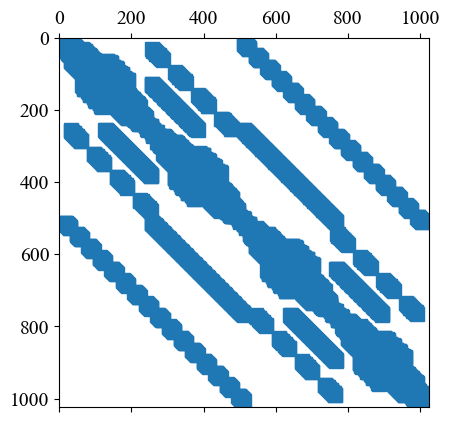

In [75]:
plt.spy(Hamiltonian_Pauli_tot_vqd.to_matrix(sparse=True))

In [72]:
np.allclose(
    hamiltonian_op.to_sparse_matrix().todense(),
    Hamiltonian_Pauli_tot_vqd.to_matrix(sparse=False),
)

True

The matrices are equal, but the eigenvalues do not correspond...

In [76]:
vals, vecs = eigsh(hamiltonian_op.to_sparse_matrix(), k=1, which="SA")
print(f"Energy of the ground state for VQE {vals[0].real}")

Energy of the ground state for VQE -4.141252385619705


### Run on AerStateBackend to compute expectation values

In [60]:
aer_backend = AerStateBackend()
nshots = None

In [69]:
from pytket.utils import get_operator_expectation_value

dict_aer_tot = []
dict_vqe_tot = []
for index, g in zip(indices, g_values_file[indices]):
    print(f"g={np.round(g,2)}")
    # create Hamiltonian in qiskit
    Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(
        g_var=g,
        m_var=m,
        omega=omega,
        fact_b_op=fact_b_op,
        fact_e_op=fact_b_op,
        lambd=0,
    ).simplify()
    # and get expectation value for qiskit circuit from statevector
    dict_vqe_tot.append(
        Statevector(qc_tot2.assign_parameters(parameters_list_file[index]))
        .expectation_value(Hamiltonian_Pauli_tot_vqd)
        .real
    )
    print(f"VQE: Expectation value at g={index} is {dict_vqe_tot[-1]}")
    # transform Hamiltonina to pytket
    hamiltonian_op = qpo_from_sparsepauliop(Hamiltonian_Pauli_tot_vqd)
    # and circuit to pytket
    circuit = qiskit_to_tk(qc_tot2.assign_parameters(parameters_list_file[index]))
    # map between qubits of the old circuit and the new circuit
    new_circuit = Circuit(len(circuit.qubits))
    orig = circuit.qubits
    new = new_circuit.qubits
    map_rename = {
        orig[0]: new[0],
        orig[1]: new[1],
        orig[2]: new[2],
        orig[3]: new[3],
        orig[4]: new[4],
        orig[6]: new[5],
        orig[8]: new[6],
        orig[9]: new[7],
        orig[7]: new[8],
        orig[5]: new[9],
    }
    circuit.rename_units(map_rename)
    # compute pytket expectation value
    dict_aer_tot.append(
        get_operator_expectation_value(
            circuit, hamiltonian_op, aer_backend, n_shots=nshots
        ).real
    )
    print(f"Aer: Expectation value at g={index} is {dict_aer_tot[-1]}")

g=0.3
VQE: Expectation value at g=1 is -19.90101599537944
Aer: Expectation value at g=1 is -2.219880049908058
g=0.7
VQE: Expectation value at g=3 is -7.720412858368777
Aer: Expectation value at g=3 is -1.5770744640983394
g=1.1
VQE: Expectation value at g=5 is -5.140877364539049
Aer: Expectation value at g=5 is -0.6216057385234997
g=1.5
VQE: Expectation value at g=7 is -3.1780190669133628
Aer: Expectation value at g=7 is 1.146736498273361
g=1.9
VQE: Expectation value at g=9 is -2.126417768655653
Aer: Expectation value at g=9 is 10.468994812954593
g=2.3
VQE: Expectation value at g=11 is -2.1101237051577924
Aer: Expectation value at g=11 is 18.092607932778094
g=2.7
VQE: Expectation value at g=13 is -2.092929014321462
Aer: Expectation value at g=13 is 27.10532341031449
g=3.1
VQE: Expectation value at g=15 is -2.076529400531739
Aer: Expectation value at g=15 is 37.442101861832754


## Using `pytket-quantinuum` to run on H-series

Here we start by using the local emulator (noiseless). Install it with `pip install pytket-quantinuum[pecos]`
(or `pip install pytket-quantinuum\[pecos\]` depending on your terminal shell): [see this website](https://cqcl.github.io/pytket-quantinuum/api/#local-emulators)

In [50]:
from pytket.extensions.quantinuum import QuantinuumBackend, QuantinuumAPIOffline

api_offline = QuantinuumAPIOffline()
backend = QuantinuumBackend(device_name="H1-1LE", api_handler=api_offline) # no need for email access becuase this is a local noiseless emulator.

In [51]:
circ_compiled = backend.get_compiled_circuit(
    circuit.measure_all(), optimisation_level=2
)

In [52]:
from pytket.circuit import OpType

print(f"Our circuit has {circ_compiled.n_gates} quantum gates in total and an overall")
print(f"depth of {circ_compiled.depth()}.")
print(f"Total number of 2qb gates is {circ_compiled.n_2qb_gates()}")
print(
    f"Of these gates {circ_compiled.n_gates_of_type(OpType.ZZMax)} are two qubit gate, ZZMax, counts."
)
print(
    f"Of these gates {circ_compiled.n_gates_of_type(OpType.ZZPhase)} are two qubit gate, ZZPhase, counts."
)

Our circuit has 248 quantum gates in total and an overall
depth of 69.
Total number of 2qb gates is 81
Of these gates 0 are two qubit gate, ZZMax, counts.
Of these gates 81 are two qubit gate, ZZPhase, counts.


For the local emulator the cost is returned as 0.0

In [53]:
n_shots = 2**10
cost = backend.cost(
    circ_compiled, n_shots=n_shots, syntax_checker="H1-1SC"
)
print("Cost of experiment in HQCs:", cost)

Cost of experiment in HQCs: 0.0


In [86]:
print(f"Number of circuits with {n_shots} shots: {int(10000/cost)}")

Number of circuits with 4096 shots: 11


In [57]:
print(f"Fidelity estimate {(0.999)**(80)}")

Fidelity estimate 0.9230793978373362


In [54]:
render_circuit_jupyter(circ_compiled)

### Emulator runs

In [ ]:
machine = "H1-1E"  # real: H1-1

emu_backend = QuantinuumBackend(device_name=machine)
# emu_backend.login()  # need to login only once
nshots = 2**10

Best to set up the loop in a way that is only submitting jobs and saving the handle for each job to disk.
Then you can do a second loop that retrieves the results using those handles, once the results are available.

In [ ]:
dict_emu_tot = []
dict_ed_tot = []
dict_vqe_tot = []
for index, g in zip(indices, g_values_file[indices]):
    print(f"g={np.round(g,2)}")
    dict_ed_tot.append(dict_ed_file[index])
    # dict_vqe_tot.append(dict_vqe_file[index])
    # XXX use last point for vqe results
    dict_vqe_tot.append(
        Statevector(
            qc_tot2.assign_parameters(parameters_list_file[index])
        ).probabilities_dict()
    )

    circuit = qiskit_to_tk(qc_tot2.assign_parameters(parameters_list_file[index]))
    # map between qubits of the old circuit and the new circuit
    new_circuit = Circuit(len(circuit.qubits))
    orig = circuit.qubits
    new = new_circuit.qubits
    map_rename = {
        orig[0]: new[0],
        orig[1]: new[1],
        orig[2]: new[2],
        orig[3]: new[3],
        orig[4]: new[4],
        orig[6]: new[5],
        orig[8]: new[6],
        orig[9]: new[7],
        orig[7]: new[8],
        orig[5]: new[9],
    }
    circuit.rename_units(map_rename)
    # render_circuit_jupyter(circuit)
    circ_compiled = emu_backend.get_compiled_circuit(
        circuit.measure_all(), optimisation_level=2
    )

    # visualize circuit
    # render_circuit_jupyter(circ_compiled)
    handle = emu_backend.process_circuit(circ_compiled, n_shots=nshots)
    result = emu_backend.get_result(handle)

    probs = probs_from_counts(emu_backend.get_result(handle).get_counts())
    dict_emu = {"".join(str(bit) for bit in k[::-1]): v for k, v in probs.items()}
    dict_emu_tot.append(dict_emu)

In [ ]:
plot_data_func(
    g_values_file[indices],
    [dict_ed_tot, dict_vqe_tot, dict_emu_tot],
    ["ED", "VQE", "H1-1E"],
    emu_backend,
    nshots,
)